***
***
Stock Market Analysis using LSTM
***
***

##### Importing packages

In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

#####Importing Datasets



In [ ]:
ds = pd.read_csv("https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv")
ds = ds.loc[::-1]

In [ ]:
ds.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [ ]:
if(ds.isnull().sum().any() == 0):
    print("No null value is present")
else:
    print("Some data cleaning needs to be done!!")

No null value is present


In [ ]:
ds.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [ ]:
ds.shape #(rows,col..)

(2035, 8)

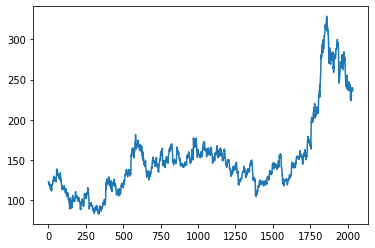

In [ ]:
ds_high = ds.reset_index()['High'] #reset the index back to the default 0, 1, 2 etc
plt.plot(ds_high)
plt.show()

In [ ]:
'''
Sensitivity of data of LSTM leads us to apply MinMaxScaler to transform
our values between 0 to 1
'''

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

sc = MinMaxScaler(feature_range= (0,1))
ds_high = sc.fit_transform(np.array(ds_high).reshape(-1,1))

#####SPLITTING DATASET 

In [ ]:
train_size = int(len(ds_high)*0.75)
test_size = len(ds_high)-train_size

In [ ]:
train_data = ds_high[0:train_size,:]
test_data = ds_high[train_size:len(ds_high),:1]

In [ ]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

print("X train shape:",x_train.shape)
print("y train shape:",y_train.shape)

print("X test shape:",x_test.shape)
print("y test shape:",y_test.shape)

X train shape: (1425, 100, 1)
y train shape: (1425,)
X test shape: (408, 100, 1)
y test shape: (408,)


***
#####Creating the LSTM **model**
***

In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,LSTM

lstm = Sequential()
lstm.add(LSTM(50, return_sequences = True,input_shape = (100,1)))
lstm.add(LSTM(50,return_sequences = True))
lstm.add(LSTM(50))

lstm.add(Dense(1))
lstm.compile(loss = "mean_squared_error",optimizer = "adam")


In [ ]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm.fit(x_train,y_train,validation_data = (x_test,y_test),epochs = 100,batch_size = 64,verbose = 1)

Epoch 1/100
23/23 [==============================] - 25s 737ms/step - loss: 0.0113 - val_loss: 0.0384
Epoch 2/100
23/23 [==============================] - 20s 859ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 3/100
23/23 [==============================] - 10s 438ms/step - loss: 8.7967e-04 - val_loss: 0.0044
Epoch 4/100
23/23 [==============================] - 9s 393ms/step - loss: 8.2870e-04 - val_loss: 0.0048
Epoch 5/100
23/23 [==============================] - 9s 395ms/step - loss: 7.6908e-04 - val_loss: 0.0036
Epoch 6/100
23/23 [==============================] - 9s 398ms/step - loss: 7.3465e-04 - val_loss: 0.0054
Epoch 7/100
23/23 [==============================] - 9s 401ms/step - loss: 7.1199e-04 - val_loss: 0.0051
Epoch 8/100
23/23 [==============================] - 9s 401ms/step - loss: 6.9375e-04 - val_loss: 0.0067
Epoch 9/100
23/23 [==============================] - 9s 400ms/step - loss: 7.0328e-04 - val_loss: 0.0034
Epoch 10/100
23/23 [==============================] - 9s 394

In [ ]:
train_pred = lstm.predict(x_train)
test_pred = lstm.predict(x_test)

In [ ]:
train_pred = sc.inverse_transform(train_pred)
test_pred = sc.inverse_transform(test_pred)

In [ ]:
math.sqrt(mean_squared_error(y_train,train_pred)) #RMSE performance metrics

135.9039326357855

In [ ]:
math.sqrt(mean_squared_error(y_test,test_pred)) #RMSE test data

228.159778777495

####Plotting

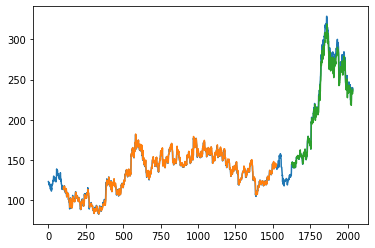

Green : Predicted data
Blue: Complete data
Orange: Train data


In [ ]:

#shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(ds_high)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_pred) + look_back,:] = train_pred

#shift test prediction for plotting
testPredictPlot = np.empty_like(ds_high)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_pred) +  (look_back * 2)+1:len(ds_high) - 1, :] = test_pred

#plot baseline and predictions
plt.plot(sc.inverse_transform(ds_high))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

print("Green : Predicted data")
print("Blue: Complete data")
print("Orange: Train data")

In [ ]:
len(test_data),x_test.shape #predict the next 28 days stock price

(509, (408, 100, 1))

In [ ]:
x_input = test_data[409:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
nextNumberOfDays = 28
i = 0

while(i < 28):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = lstm.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i+1
    
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = lstm.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.61230916]
101
1 day input [0.86013417 0.85464525 0.84448059 0.8072779  0.71843871 0.66192316
 0.67696686 0.67554381 0.67310429 0.68428542 0.68936776 0.70217524
 0.71803212 0.72941655 0.73144948 0.74486684 0.76926205 0.75991055
 0.74242732 0.73958122 0.74771295 0.75991055 0.7584875  0.76621264
 0.75462492 0.76316324 0.79670665 0.80585485 0.7889815  0.78003659
 0.73978451 0.73002643 0.73490547 0.74872942 0.75991055 0.75462492
 0.75401504 0.76174019 0.7737345  0.82008538 0.80585485 0.81154706
 0.77434438 0.78633869 0.79284407 0.78328929 0.77109169 0.74385038
 0.71193332 0.68733482 0.67818662 0.65257166 0.64301687 0.65643423
 0.67656028 0.67371417 0.65114861 0.65521447 0.66761537 0.67838992
 0.69993901 0.63122586 0.63508843 0.64098394 0.64545639 0.64118723
 0.63854442 0.63081927 0.62472047 0.6330555  0.64728603 0.6574507
 0.66761537 0.66720878 0.64159382 0.62776987 0.63651149 0.63630819
 0.62980281 0.62817646 0.63813783 0.65358813 0.63183574 0.57653995
 0.57816629 0.57613336 0.61943484 

In [ ]:
day_new = np.arange(1,101)
day_pred = np.arange(101,129)

In [ ]:
print("Day-new shape:",day_new.shape,"\nDay-pred shape:",day_pred.shape)

Day-new shape: (100,) 
Day-pred shape: (28,)


In [ ]:
ds_new = ds_high.tolist()
ds_new.extend(lst_output)

len(ds_high)

2035

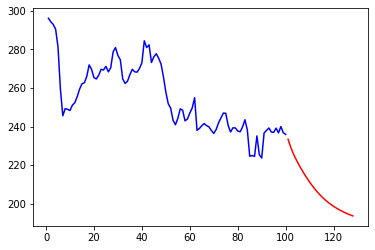

In [ ]:
plt.plot(day_new,sc.inverse_transform(ds_high[1935:]),'b')
plt.plot(day_pred,sc.inverse_transform(lst_output),'r')
plt.show()

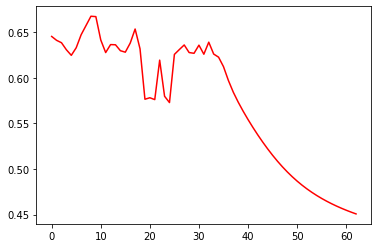

In [ ]:
ds_new = ds_high.tolist()
ds_new.extend(lst_output)
plt.plot(ds_new[2000:],'r')
plt.show()

In [ ]:
ds_new = sc.inverse_transform(ds_new).tolist()

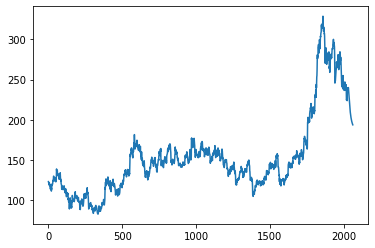

In [ ]:
plt.plot(ds_new)
plt.show()